In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_recall_curve

from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras_tuner as kt

import xgboost as xgb

from scipy.stats import randint

import seaborn as sns

import joblib

<h1>Data Cleaning and Preprocessing</h1>

In [ ]:
# Load dataset
dataset = pd.read_csv('Survival_Data.csv')

In [3]:
#Drop undesired features
dataset = dataset.drop(['studyid', 'site', 'strength_comfort_religion', 'petition_prayer_health', 'intercessory_prayers_health'], axis = 1)

In [4]:
# Separate the dataset into numerical and categorical features
numerical_features = dataset.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = dataset.select_dtypes(exclude=['int64', 'float64']).columns.tolist()

In [5]:
# Use median imputation on the numerical features for missing values
dataset[numerical_features] = dataset[numerical_features].fillna(dataset[numerical_features].median())

# Use mode imputation on the categorical features for missing values
for col in categorical_features:
    dataset[col] = dataset[col].fillna(dataset[col].mode().iloc[0])

In [ ]:
# Convert binary categorical variables ('Yes'/'No') into 1/0
binary_columns = [col for col in categorical_features if dataset[col].nunique() == 2]
for col in binary_columns:
    unique_values = dataset[col].unique()
    if set(unique_values) == {'Yes', 'No'}:
        dataset[col] = dataset[col].replace({'Yes': 1, 'No': 0})
    elif set(unique_values) == {'Not impaired', 'Impaired'}:
        dataset[col] = dataset[col].replace({'Impaired': 1, 'Not impaired': 0})
    else:
        mapping = {unique_values[0]: 1, unique_values[1]: 0}
        dataset[col] = dataset[col].map(mapping)


# Remaining categorical variables (multi-category)
multi_category_columns = [col for col in categorical_features if col not in binary_columns]

In [7]:
# One-hot encode categorical variables
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_categorical = encoder.fit_transform(dataset[multi_category_columns])
encoded_categorical_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(multi_category_columns))

In [8]:
# Drop original categorical columns and merge encoded ones
dataset = dataset.drop(multi_category_columns, axis=1)
dataset = pd.concat([dataset, encoded_categorical_df], axis=1)

# Fix special column (< causes issues)
dataset = dataset.rename(columns={
    'agecat_>=55-<65': 'agecat_55_to_65',
    'agecat_>=65': 'agecat_65_plus'
})

In [9]:
# Separate features and target
X = dataset.drop('died_2_year', axis=1)
y = dataset['died_2_year']

In [10]:
# Scale numerical features
scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])

<h1>Basic Data Visualization</h1>

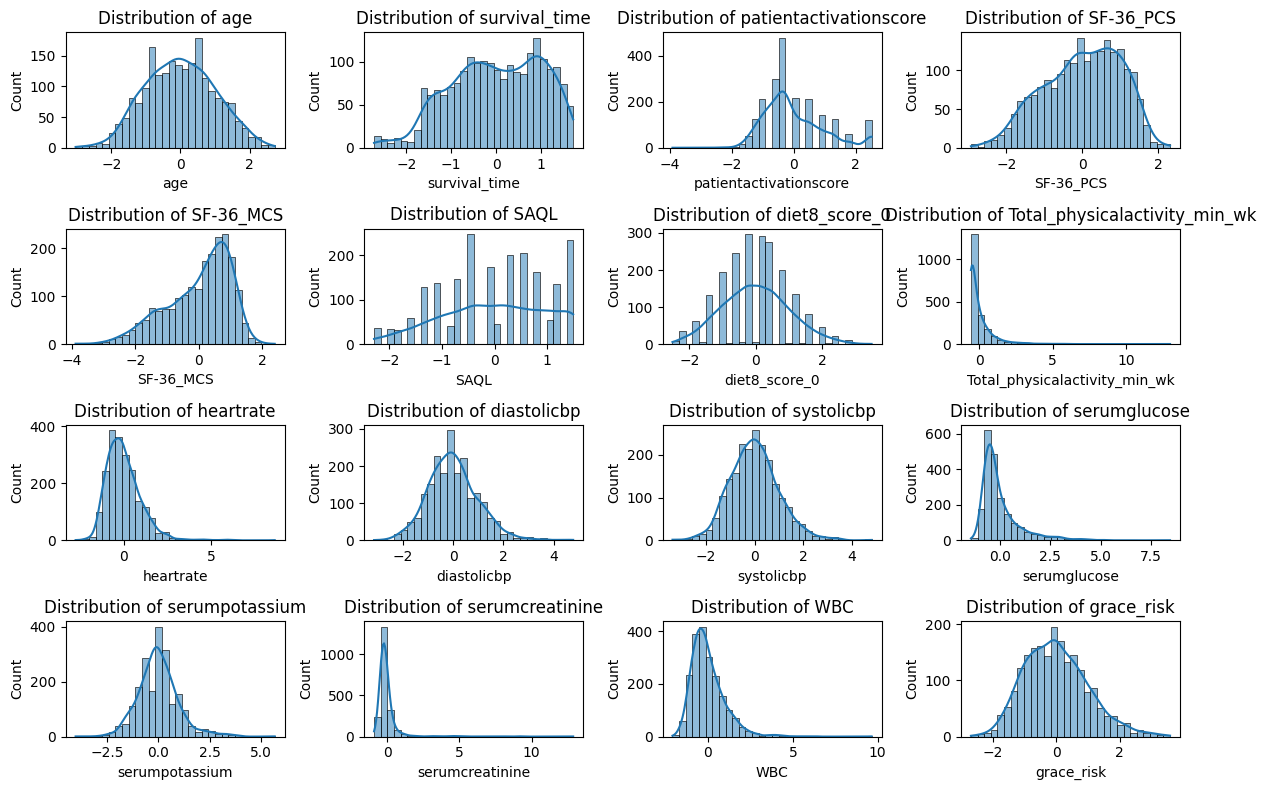

In [ ]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(numerical_features, 1):
    plt.subplot(4, 4, i)
    # Include Kernal Density Estimator
    sns.histplot(X[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

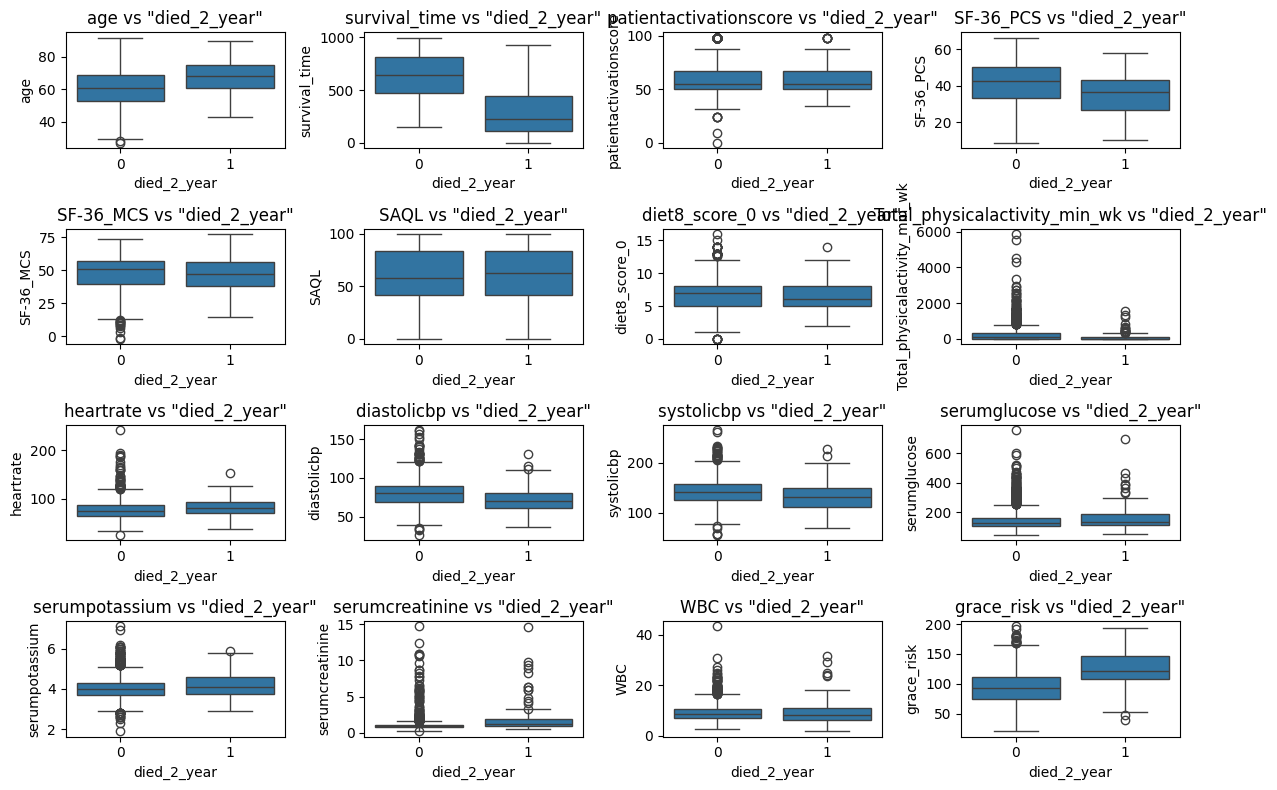

In [29]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(numerical_features, 1):
    plt.subplot(4, 4, i)  
    sns.boxplot(x=dataset['died_2_year'], y=dataset[col])
    plt.title(f'{col} vs "died_2_year"')
plt.tight_layout()
plt.show()

C:\Users\Dalton\AppData\Local\Temp\ipykernel_43040\2764742200.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=dataset['died_2_year'], palette="coolwarm")


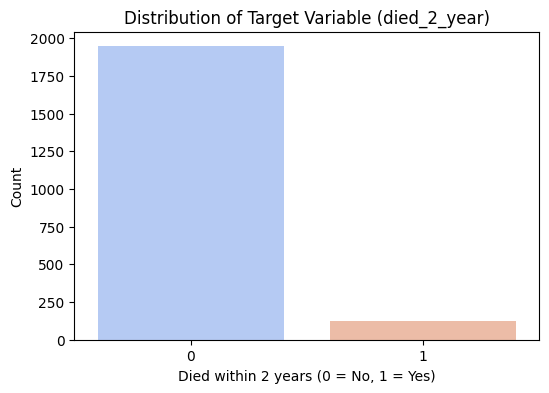

In [30]:
# Countplot for target variable
plt.figure(figsize=(6, 4))
sns.countplot(x=dataset['died_2_year'], palette="coolwarm")
plt.title("Distribution of Target Variable (died_2_year)")
plt.xlabel("Died within 2 years (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

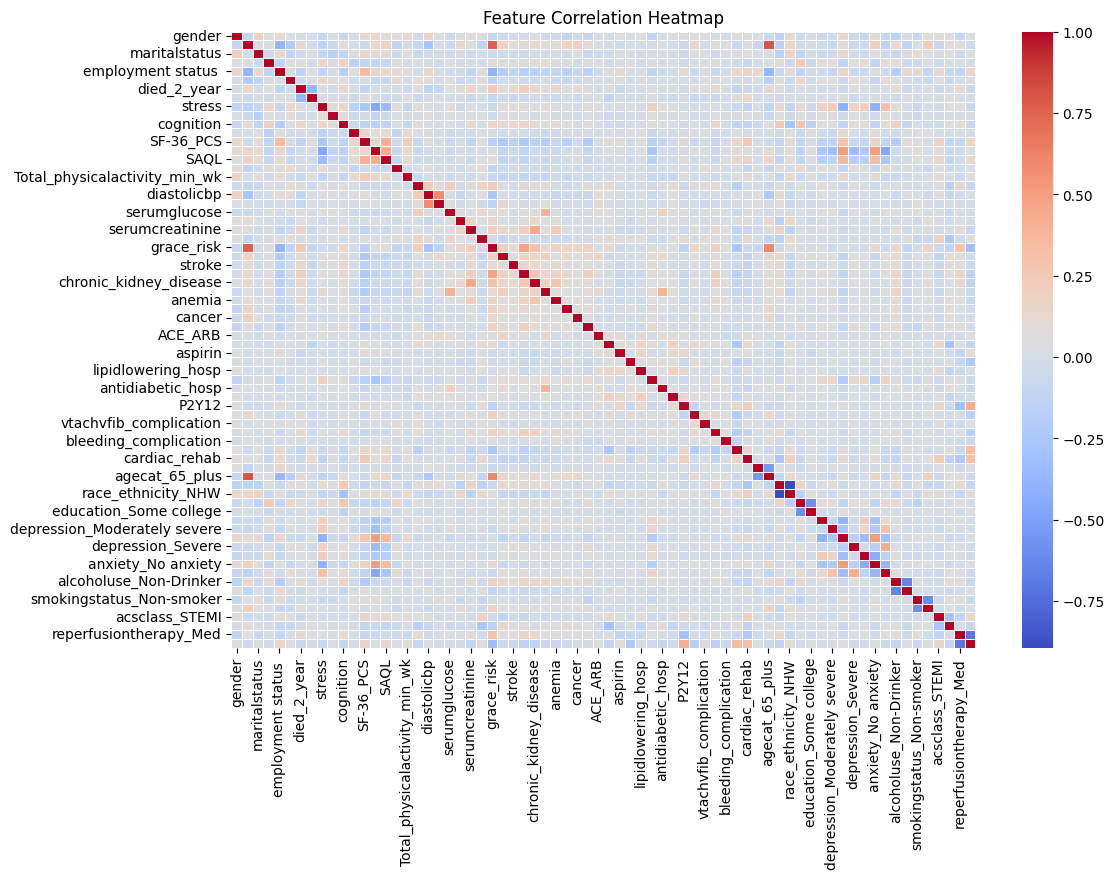

In [31]:
# Compute correlation matrix
correlation_matrix = dataset.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

<h1>Basic Training Model Architecture</h1>

In [81]:
class ModelTrainer:
    def __init__(self, test_size=0.1, val_size=0.1, resample_strategy='smote'):
        """
        resample_strategy: 'smote' for oversampling, None for no resampling.
        """
        self.test_size = test_size
        self.val_size = val_size
        self.resample_strategy = resample_strategy
        
        self.X_train, self.X_val, self.X_test, self.y_train, self.y_val, self.y_test = self.split()
        self.models = {}

    def split(self):
        """Apply SMOTE before splitting to expand dataset size."""
        global X, y  # Ensure you're modifying the main dataset

        if self.resample_strategy == 'smote':
            smote = SMOTE(sampling_strategy=0.5, random_state=42)  
            X, y = smote.fit_resample(X, y)  # Apply SMOTE to the entire dataset

        # Now split the expanded dataset
        X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=(self.test_size + self.val_size), stratify=y, random_state=42)
        X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, stratify=y_rest, random_state=42)

        return X_train, X_val, X_test, y_train, y_val, y_test
    
    def train_model(self, model_name, model, param_grid=None, search_type='grid', cv_folds=5):
        """Train a model with optional hyperparameter tuning and class weighting."""
        
        # Apply class weighting if supported
        if hasattr(model, "class_weight"):
            model.set_params(class_weight="balanced")

        if param_grid:
            search_cv = GridSearchCV if search_type == 'grid' else RandomizedSearchCV
            model = search_cv(model, param_grid, cv=StratifiedKFold(n_splits=cv_folds), scoring='accuracy', n_jobs=-1, verbose=1)
            model.fit(self.X_train, self.y_train)
            model = model.best_estimator_
            best_params = {k: v for k, v in model.get_params().items() if v is not None}
            print(f"Best Parameters for {model_name}: {best_params}")
        else:
            model.fit(self.X_train, self.y_train)

        self.models[model_name] = model
        self.evaluate_model(model_name)
    
    def evaluate_model(self, model_name, threshold=0.4):
        """Evaluate the model using accuracy and confusion matrix with custom threshold."""
        model = self.models[model_name]

        # Get probabilities instead of hard predictions
        y_train_probs = model.predict_proba(self.X_train)[:, 1]
        y_val_probs = model.predict_proba(self.X_val)[:, 1]
        y_test_probs = model.predict_proba(self.X_test)[:, 1]

        # Apply threshold manually
        y_train_pred = (y_train_probs >= threshold).astype(int)
        y_val_pred = (y_val_probs >= threshold).astype(int)
        y_test_pred = (y_test_probs >= threshold).astype(int)

        # Calculate accuracy scores
        train_acc = accuracy_score(self.y_train, y_train_pred)
        val_acc = accuracy_score(self.y_val, y_val_pred)
        test_acc = accuracy_score(self.y_test, y_test_pred)

        print(f"\n=== {model_name} Performance (Threshold = {threshold}) ===")
        print(f"Train Accuracy: {train_acc:.4f}")
        print(f"Validation Accuracy: {val_acc:.4f}")
        print(f"Test Accuracy: {test_acc:.4f}")
        print("\nClassification Report:\n", classification_report(self.y_test, y_test_pred))

        self.plot_confusion_matrix(self.y_test, y_test_pred, model_name)

    def plot_confusion_matrix(self, y_true, y_pred, title):
        """Plot confusion matrix."""
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Survived', 'Died'], yticklabels=['Survived', 'Died'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'Confusion Matrix: {title}')
        plt.show()

    def optimize_threshold(self, model_name):
        """Optimize classification threshold based on Precision-Recall."""
        model = self.models[model_name]
        y_probs = model.predict_proba(self.X_val)[:, 1]  # Get probabilities for class 1
        precisions, recalls, thresholds = precision_recall_curve(self.y_val, y_probs)

        # Find the best threshold (e.g., where precision and recall are balanced)
        f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)
        best_threshold = thresholds[f1_scores.argmax()]
        
        print(f"Optimized threshold for {model_name}: {best_threshold:.2f}")
        return best_threshold

<h1>Model Comparisons</h1>

In [82]:
trainer = ModelTrainer(resample_strategy='smote')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters for Random Forest: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt', 'min_impurity_decrease': 0.0, 'min_samples_leaf': 8, 'min_samples_split': 18, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 61, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

=== Random Forest Performance (Threshold = 0.4) ===
Train Accuracy: 0.9348
Validation Accuracy: 0.9144
Test Accuracy: 0.9281

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.90      0.94       194
           1       0.83      0.98      0.90        98

    accuracy                           0.93       292
   macro avg       0.91      0.94      0.92       292
weighted avg       0.94      0.93      0.93       292



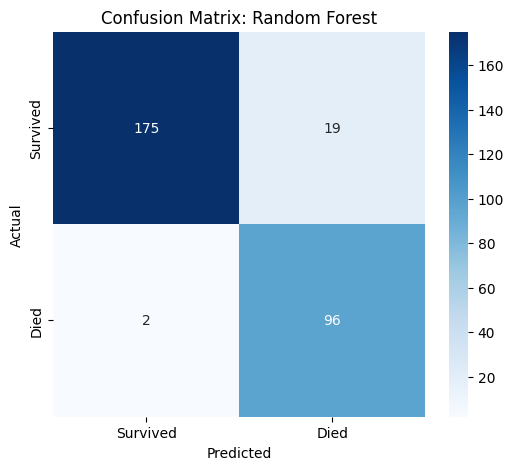

In [83]:
# RandomForest Classfier
rf_params = {
    'n_estimators': randint(50, 100),
    'max_depth': randint(3, 7),
    'min_samples_leaf': randint(5, 20),
    'min_samples_split': randint(5, 20),
}
trainer.train_model("Random Forest", RandomForestClassifier(random_state=42), param_grid=rf_params, search_type='random')

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters for XGBoost: {'objective': 'binary:logistic', 'enable_categorical': False, 'eval_metric': 'logloss', 'learning_rate': 0.3, 'max_depth': 5, 'missing': nan, 'n_estimators': 100, 'random_state': 42}

=== XGBoost Performance (Threshold = 0.4) ===
Train Accuracy: 1.0000
Validation Accuracy: 0.9658
Test Accuracy: 0.9932

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       194
           1       1.00      0.98      0.99        98

    accuracy                           0.99       292
   macro avg       0.99      0.99      0.99       292
weighted avg       0.99      0.99      0.99       292



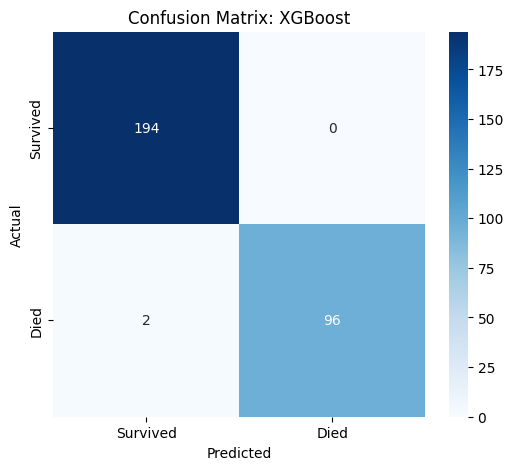

In [84]:
# XG Boost
xgb_params = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
}
trainer.train_model("XGBoost", xgb.XGBClassifier(random_state=42, eval_metric="logloss"), param_grid=xgb_params)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters for Logistic Regression: {'C': 10, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'auto', 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

=== Logistic Regression Performance (Threshold = 0.4) ===
Train Accuracy: 0.9288
Validation Accuracy: 0.8870
Test Accuracy: 0.9041

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.89      0.92       194
           1       0.81      0.94      0.87        98

    accuracy                           0.90       292
   macro avg       0.89      0.91      0.90       292
weighted avg       0.91      0.90      0.91       292



C:\Users\Dalton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


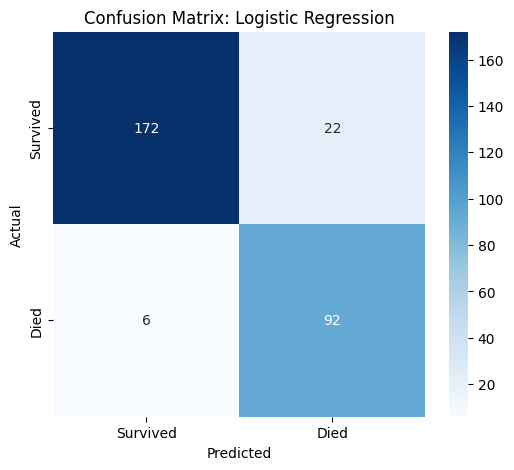

In [85]:
# Logistic Regression
param_grid = {
    'C': [0.1, 1, 3, 5, 10],
    'solver': ['liblinear', 'lbfgs'],
    'max_iter': [100, 200, 500]
}

# Initialize Base Model
base_model = LogisticRegression(penalty='l2', random_state=42)

trainer.train_model('Logistic Regression', base_model, param_grid=param_grid, search_type='grid')

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Parameters for Simple Vector Machine: {'C': 100, 'break_ties': False, 'cache_size': 200, 'class_weight': 'balanced', 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}

=== Simple Vector Machine Performance (Threshold = 0.4) ===
Train Accuracy: 1.0000
Validation Accuracy: 0.9658
Test Accuracy: 0.9897

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       194
           1       0.98      0.99      0.98        98

    accuracy                           0.99       292
   macro avg       0.99      0.99      0.99       292
weighted avg       0.99      0.99      0.99       292



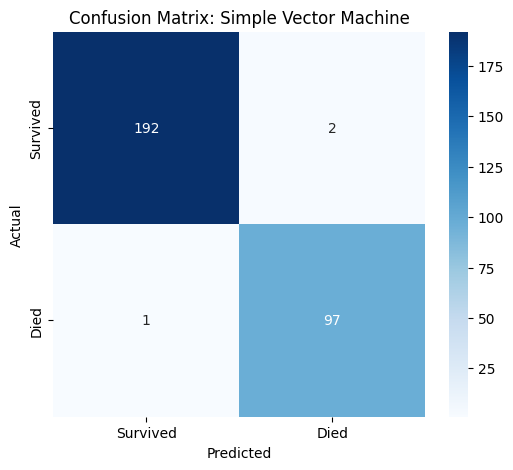

In [86]:
# Simple Vector Machine
param_grid = {
    'C': [0.1, 1, 10, 100], 
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

trainer.train_model('Simple Vector Machine', SVC(random_state=42, probability=True), param_grid=param_grid, search_type='grid')

<h1>Neural Network Approach</h1>

In [88]:
# Split into train, validation, and test sets
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)

# Compute class weights to handle imbalance
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

Epoch 1/100


C:\Users\Dalton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7495 - loss: 0.5605 - val_accuracy: 0.8425 - val_loss: 0.3342 - learning_rate: 0.0010
Epoch 2/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8976 - loss: 0.2649 - val_accuracy: 0.8733 - val_loss: 0.2501 - learning_rate: 0.0010
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9377 - loss: 0.1749 - val_accuracy: 0.9521 - val_loss: 0.1575 - learning_rate: 0.0010
Epoch 4/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9544 - loss: 0.1358 - val_accuracy: 0.9623 - val_loss: 0.1086 - learning_rate: 0.0010
Epoch 5/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9528 - loss: 0.1428 - val_accuracy: 0.9658 - val_loss: 0.0805 - learning_rate: 0.0010
Epoch 6/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9604 - loss: 0.1055 - val_accuracy: 0.9692 - val_loss: 0.0623 - learning_rate: 0.0010
Epoch 7/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9660 - loss: 0.0968 - val_accuracy: 0.979

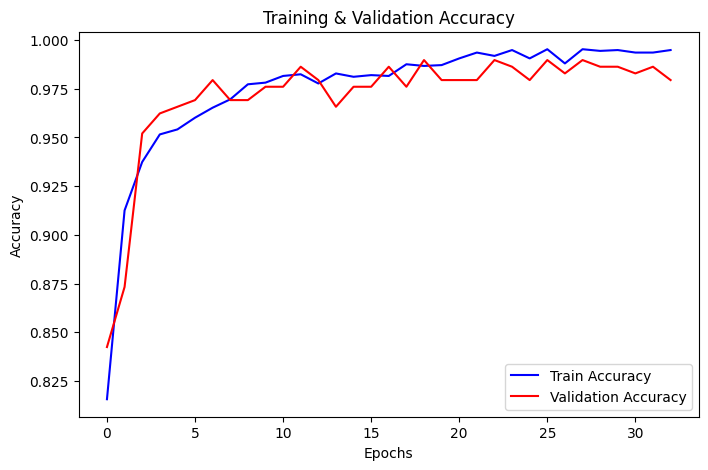

In [89]:
# Build Neural Network
model = Sequential()

# Input Layer
model.add(Dense(512, input_shape=(X_train.shape[1],), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Hidden Layers
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Output Layer
model.add(Dense(1, activation='sigmoid'))

# Compile Model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train Model
history = model.fit(
    X_train, y_train, 
    epochs=100, 
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
    ],
    verbose=1
)

# Evaluate Model on Test Set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

# Extract Training & Validation Accuracy
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

print(f"Final Train Accuracy: {train_acc[-1]:.4f}")
print(f"Final Validation Accuracy: {val_acc[-1]:.4f}")

# Plot Training vs Validation Accuracy
plt.figure(figsize=(8, 5))
plt.plot(train_acc, label='Train Accuracy', color='blue')
plt.plot(val_acc, label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


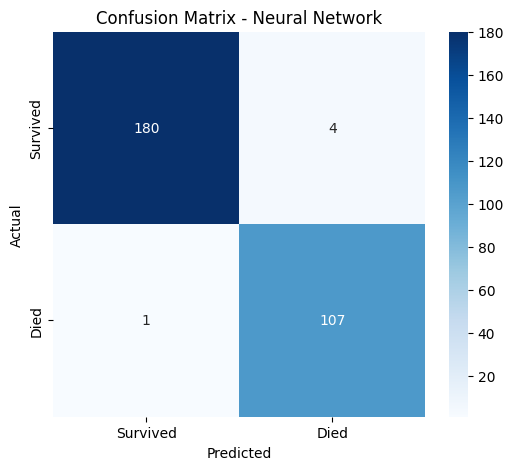


Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99       184
           1       0.96      0.99      0.98       108

    accuracy                           0.98       292
   macro avg       0.98      0.98      0.98       292
weighted avg       0.98      0.98      0.98       292



In [90]:
# Generate Predictions
y_pred_probs = model.predict(X_test)  # Get probabilities
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()  # Convert to binary classes

# Compute & Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Survived', 'Died'], yticklabels=['Survived', 'Died'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Neural Network')
plt.show()

# Print Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred_classes))

In [ ]:
# Dictionary to store test accuracies
test_accuracies = {}

# Store test accuracies for scikit-learn models
for model_name, model in trainer.models.items():
    # Get probabilities
    y_test_probs = model.predict_proba(trainer.X_test)[:, 1] 
    # Use threshold 0.4 (SAME AS THAT USED IN CLASS ABOVE)
    y_test_pred = (y_test_probs >= 0.4).astype(int)
    test_acc = accuracy_score(trainer.y_test, y_test_pred)
    test_accuracies[model_name] = test_acc

# Store test accuracy for neural network
test_accuracies["Neural Network"] = test_acc

# Find the best model
best_model_name = max(test_accuracies, key=test_accuracies.get)
best_test_acc = test_accuracies[best_model_name]

print(f"\nBest Model: {best_model_name} with Test Accuracy: {best_test_acc:.4f}")

# Save the best model
if best_model_name == "Neural Network":
    model.save("best_neural_network_model.h5")
    print("Neural Network model saved as 'best_neural_network_model.h5'")
else:
    best_model = trainer.models[best_model_name]
    joblib.dump(best_model, f"best_model_{best_model_name.replace(' ', '_')}.pkl")
    print(f"Scikit-learn model saved as 'best_model_{best_model_name.replace(' ', '_')}.pkl'")



Best Model: XGBoost with Test Accuracy: 0.9932
Scikit-learn model saved as 'best_model_XGBoost.pkl'
